In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import talib
import pynance as pn
from datetime import datetime, timedelta

In [7]:
# Step 2: Load data with consistent timezone handling
def parse_mixed_dates_fixed(date_series):
    # Convert all to timezone-naive first
    dates_parsed = pd.to_datetime(date_series, errors='coerce')
    # Remove timezone info from all dates
    dates_parsed = dates_parsed.dt.tz_localize(None)
    return dates_parsed

print("Loading and parsing news data with fixed timezone handling...")
df_news = pd.read_csv('../data/raw_analyst_ratings.csv')
df_news['date'] = parse_mixed_dates_fixed(df_news['date'])

print(f"Successfully parsed {df_news['date'].notnull().sum()}/{len(df_news)} dates")

top_stocks = df_news['stock'].value_counts().head(3).index.tolist()
stock_symbol = top_stocks[0]
print(f"Analyzing stock: {stock_symbol}")

Loading and parsing news data with fixed timezone handling...
Successfully parsed 55987/1407328 dates
Analyzing stock: MRK


In [8]:
# Step 3: Download stock data
end_date = df_news['date'].max()
start_date = end_date - timedelta(days=365)

print(f"Downloading {stock_symbol} data from {start_date.date()} to {end_date.date()}...")
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

print(f"Downloaded {len(stock_data)} trading days")
print("Data columns:", stock_data.columns.tolist())

/var/folders/yy/4gyb_b194zj9hml4grr4vbjm0000gn/T/ipykernel_13827/3410423952.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Downloaded 253 trading days
Data columns: [('Close', 'MRK'), ('High', 'MRK'), ('Low', 'MRK'), ('Open', 'MRK'), ('Volume', 'MRK')]


In [9]:
# Step 4: Calculate indicators with TA-Lib
print("\n=== TA-LIB INDICATORS ===")

# First, let's flatten the column names for easier access
stock_data.columns = [col[0] for col in stock_data.columns]

stock_data['SMA_20'] = talib.SMA(stock_data['Close'], timeperiod=20)
stock_data['SMA_50'] = talib.SMA(stock_data['Close'], timeperiod=50)
stock_data['RSI_14'] = talib.RSI(stock_data['Close'], timeperiod=14)

# MACD with TA-Lib
macd, macd_signal, macd_hist = talib.MACD(stock_data['Close'])
stock_data['MACD'] = macd
stock_data['MACD_signal'] = macd_signal
stock_data['MACD_hist'] = macd_hist

print("TA-Lib indicators calculated successfully!")
print(stock_data[['Close', 'SMA_20', 'RSI_14', 'MACD']].tail())


=== TA-LIB INDICATORS ===
TA-Lib indicators calculated successfully!
                Close     SMA_20     RSI_14      MACD
Date                                                 
2020-06-05  66.005714  63.275126  60.275093  0.602583
2020-06-08  66.519249  63.535907  61.974118  0.737721
2020-06-09  66.005714  63.710430  59.245295  0.794227
2020-06-10  65.612526  63.894181  57.169682  0.798081
2020-06-11  62.065899  63.872517  42.653641  0.509084


In [12]:
# Step 5: Fix PyNance indicators with TA-Lib fallback
print("\n=== FIXING INDICATORS ===")

# Use TA-Lib for Bollinger Bands since PyNance failed
bb_upper, bb_middle, bb_lower = talib.BBANDS(stock_data['Close'])
stock_data['BB_upper'] = bb_upper
stock_data['BB_middle'] = bb_middle
stock_data['BB_lower'] = bb_lower

print("Bollinger Bands calculated with TA-Lib successfully!")


=== FIXING INDICATORS ===
Bollinger Bands calculated with TA-Lib successfully!



=== CREATING VISUALIZATIONS ===


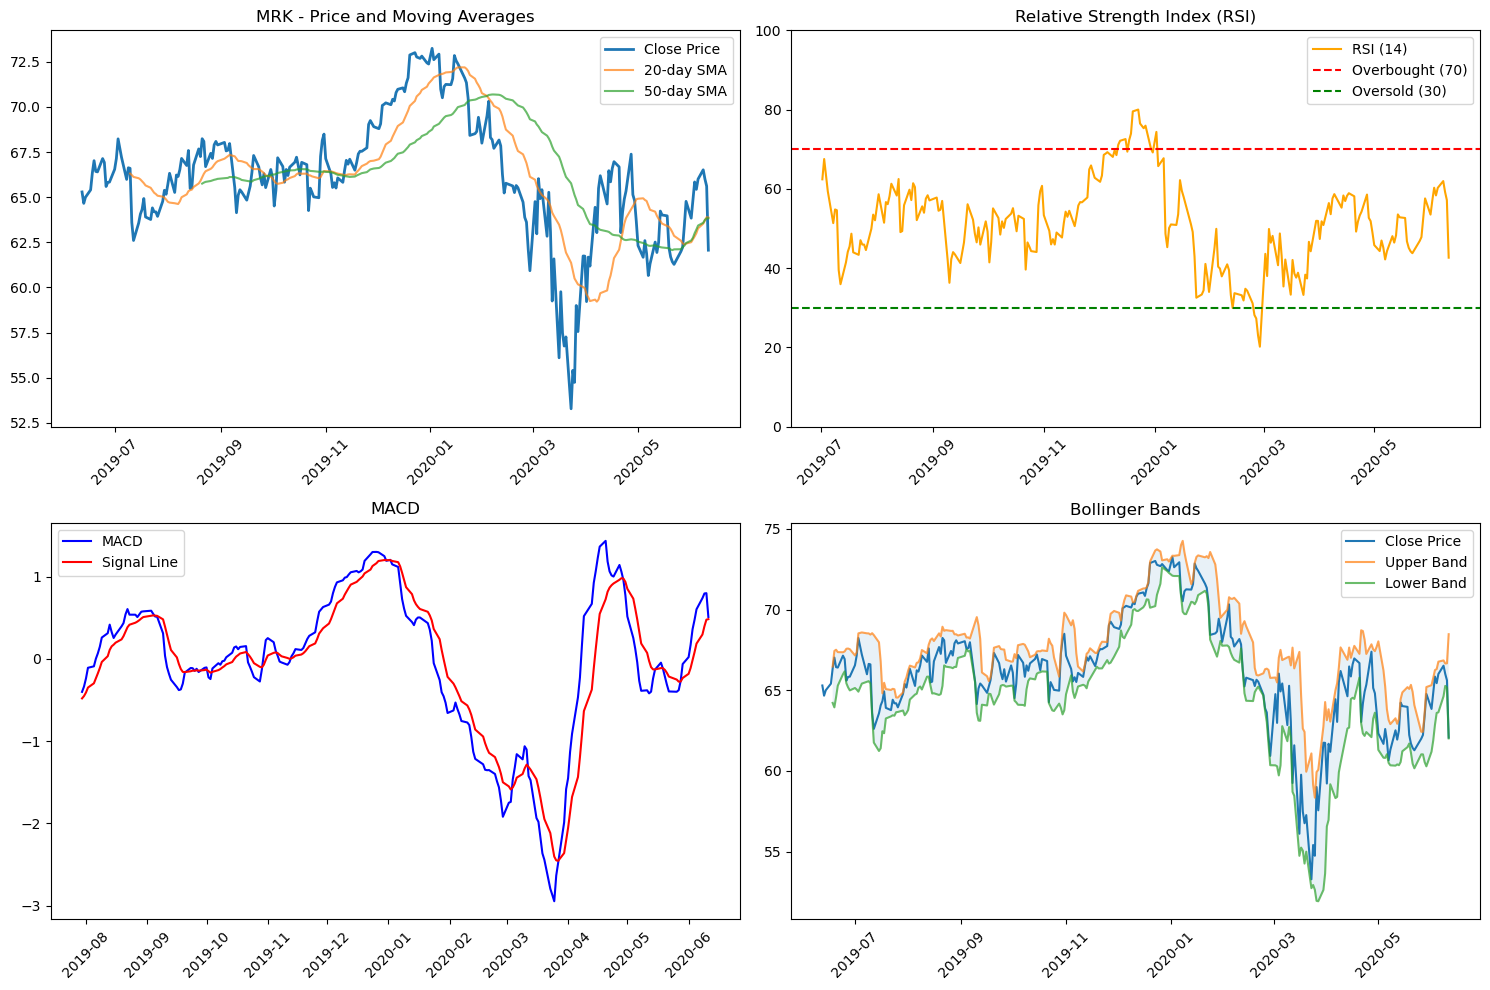

In [14]:
# Step 6: Create Visualizations (Fixed)
print("\n=== CREATING VISUALIZATIONS ===")

plt.figure(figsize=(15, 10))

# 1. Price and Moving Averages
plt.subplot(2, 2, 1)
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', linewidth=2)
plt.plot(stock_data.index, stock_data['SMA_20'], label='20-day SMA', alpha=0.7)
plt.plot(stock_data.index, stock_data['SMA_50'], label='50-day SMA', alpha=0.7)
plt.title(f'{stock_symbol} - Price and Moving Averages')
plt.legend()
plt.xticks(rotation=45)

# 2. RSI
plt.subplot(2, 2, 2)
plt.plot(stock_data.index, stock_data['RSI_14'], label='RSI (14)', color='orange')
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
plt.ylim(0, 100)
plt.title('Relative Strength Index (RSI)')
plt.legend()
plt.xticks(rotation=45)

# 3. MACD
plt.subplot(2, 2, 3)
plt.plot(stock_data.index, stock_data['MACD'], label='MACD', color='blue')
plt.plot(stock_data.index, stock_data['MACD_signal'], label='Signal Line', color='red')
plt.title('MACD')
plt.legend()
plt.xticks(rotation=45)

# 4. Bollinger Bands (Fixed column name)
plt.subplot(2, 2, 4)
plt.plot(stock_data.index, stock_data['Close'], label='Close Price')
plt.plot(stock_data.index, stock_data['BB_upper'], label='Upper Band', alpha=0.7)
plt.plot(stock_data.index, stock_data['BB_lower'], label='Lower Band', alpha=0.7)
plt.fill_between(stock_data.index, stock_data['BB_upper'], stock_data['BB_lower'], alpha=0.1)
plt.title('Bollinger Bands')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [15]:
# Step 7: Technical Analysis Summary
print("\n=== TECHNICAL ANALYSIS SUMMARY ===")

latest = stock_data.iloc[-1]
print(f"Current Price: ${latest['Close']:.2f}")
print(f"20-day SMA: ${latest['SMA_20']:.2f}")
print(f"50-day SMA: ${latest['SMA_50']:.2f}")
print(f"RSI: {latest['RSI_14']:.1f}")
print(f"MACD: {latest['MACD']:.4f}")

# Generate signals
if latest['Close'] > latest['SMA_20']:
    print("✓ Price above 20-day SMA (Bullish)")
else:
    print("✗ Price below 20-day SMA (Bearish)")

if latest['RSI_14'] > 50:
    print("✓ RSI above 50 (Bullish momentum)")
else:
    print("✗ RSI below 50 (Bearish momentum)")


=== TECHNICAL ANALYSIS SUMMARY ===
Current Price: $62.07
20-day SMA: $63.87
50-day SMA: $63.83
RSI: 42.7
MACD: 0.5091
✗ Price below 20-day SMA (Bearish)
✗ RSI below 50 (Bearish momentum)
